# JPMorgan Chase & Co. Quantitative Research Job Simulation
## Task 1

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from pmdarima import auto_arima

## Step 0: Data Exploration

In [40]:
# Load the data
df = pd.read_csv(r'C:\Users\Babanz\VS\quant\JPMC-Forage\Data\Nat_Gas.csv', parse_dates=['Dates'], date_format='%d/%m/%y')

# Select what data to view
data_view = 2

match data_view:
    case 1:
        df.info()
    case 2:
        print(df.head()) # or tail()
    case 3:
        print(df.describe())

      Dates  Prices
0  10/31/20    10.1
1  11/30/20    10.3
2  12/31/20    11.0
3   1/31/21    10.9
4   2/28/21    10.9


## Step 1: Check for stationarity in the time-series data
### Method 1: Check time-series plot
- The upward trend in the time-series plot indicates nonstationarity

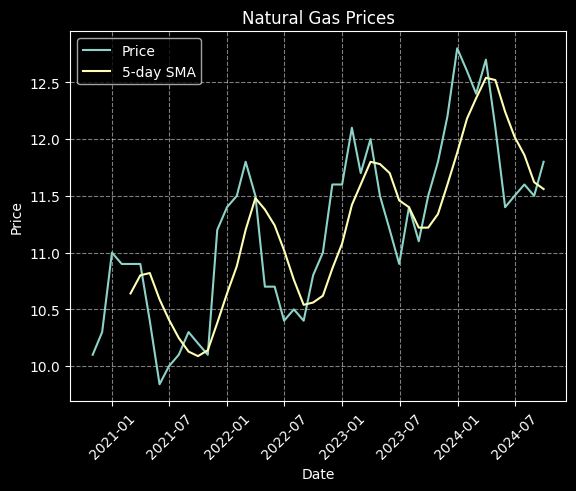

In [41]:
def plot_format(ax):
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title('Natural Gas Prices')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()

# Reformat dates
df['Dates'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')

# Get price and data values
prices = df['Prices'].values
dates = df['Dates'].values

# Calculate Simple Moving Average (SMA)
n = 5
sma = df['Prices'].rolling(window=n).mean()

# Plotting
plt.style.use('dark_background')
fig, ax = plt.subplots()
ax.plot(dates, prices, label='Price', linestyle='-')
ax.plot(dates, sma, label=f'{n}-day SMA', linestyle='-')
plot_format(ax=ax)
plt.show()

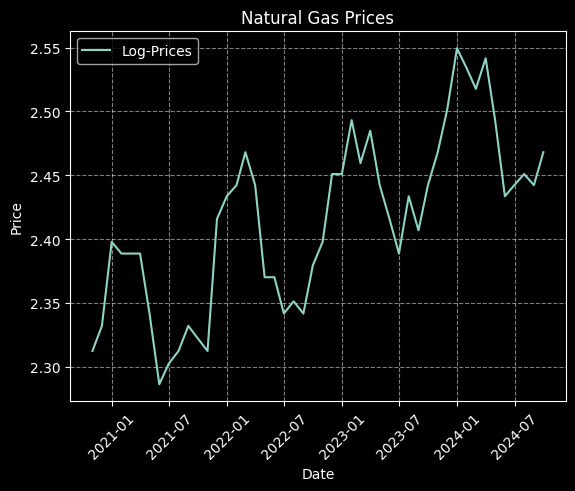

In [42]:
# Visualise log data
df_log = pd.DataFrame({
    'Log-Prices': np.log(prices),
    'Dates': dates
})

fig, ax = plt.subplots()
ax.plot(df_log['Dates'], df_log['Log-Prices'], label='Log-Prices', linestyle='-')
plot_format(ax=ax)
plt.show()

### Method 2: Check ACF and PACF plots

- This train-test split is used to verify if our SARIMAX approach would be valid in forecasting unseen data

In [43]:
# Create train-test split to validate model
n_split = 0
mask = (df.index < len(df) - n_split)
df_train = df[mask].copy()
df_test = df[~mask].copy()

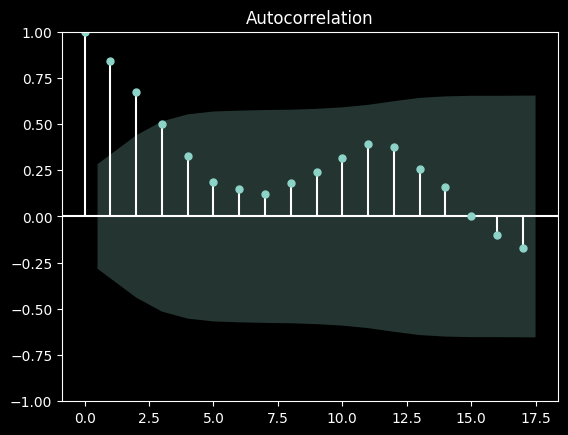

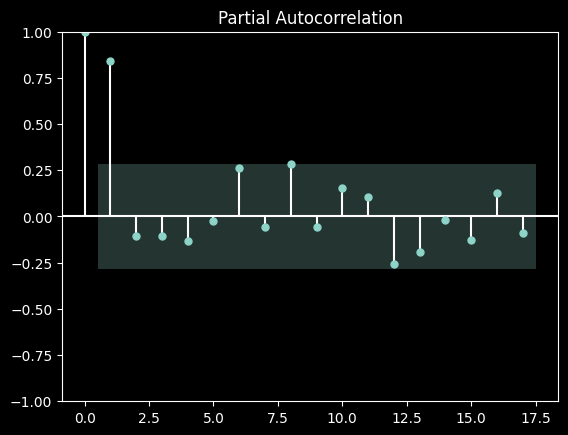

In [44]:
# Autocorrelation Function plot
acf_train = plot_acf(df_train['Prices'])

# Partial Autocorrelation Function plot
pacf_train = plot_pacf(df_train['Prices'])

### Method 3: ADF test
- Augmented Dickey–Fuller is a hypothesis test to determine stationarity where $H_0$: There is a unit root (nonstationary)
- If $p > 0.05$ (5% significance level), we do NOT reject the null hypothesis hence the time-series is nonstationary

In [45]:
# ADF test
def adf_test(X, significance_level=0.05):
    adf_ = adfuller(X)
    p_value = adf_[1]
    print(f'p-value = {p_value}')

    # When to reject H_0
    if p_value < significance_level:
        print('Reject null hypothesis therefore data is stationary')
    else:
        print('Do NOT reject null hypothesis therefore data is nonstationary')

adf_test(df_train['Prices'])

p-value = 0.9732574388448694
Do NOT reject null hypothesis therefore data is nonstationary


## Step 2: Transform to stationary via differencing

- The differencing looks more stationary as it exhibts less of an increasing upward trend

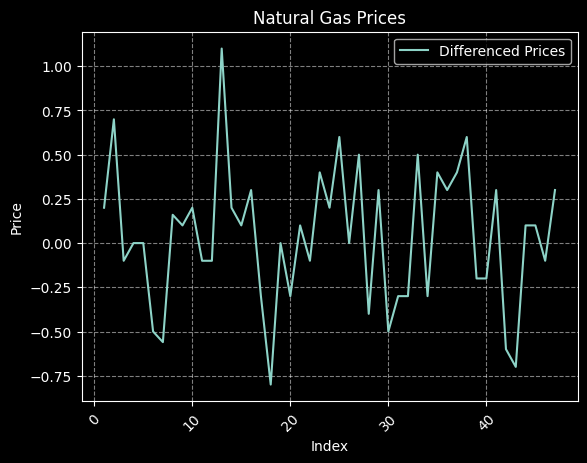

In [46]:
# Create the y_t - y_{t-1} data
df_train_diff = df_train.diff().dropna()

fig, ax = plt.subplots()
ax.plot(df_train_diff.index, df_train_diff['Prices'], label='Differenced Prices', linestyle='-')
plot_format(ax=ax)
ax.set_xlabel('Index')
plt.show()

- We can therefore set $d = 1$ for the standard ARIMA model using $\text{ARIMA}(p, d, q)$

p-value = 1.754169685294091e-09
Reject null hypothesis therefore data is stationary


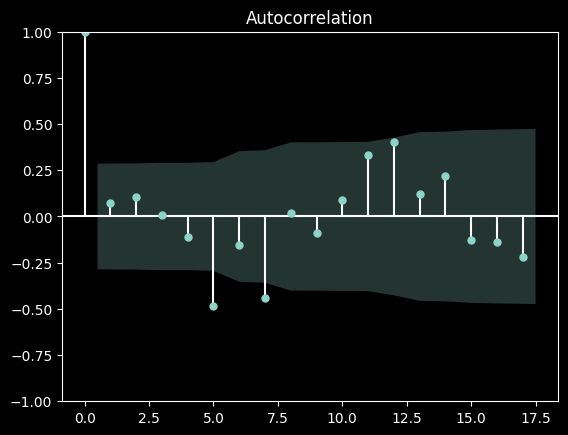

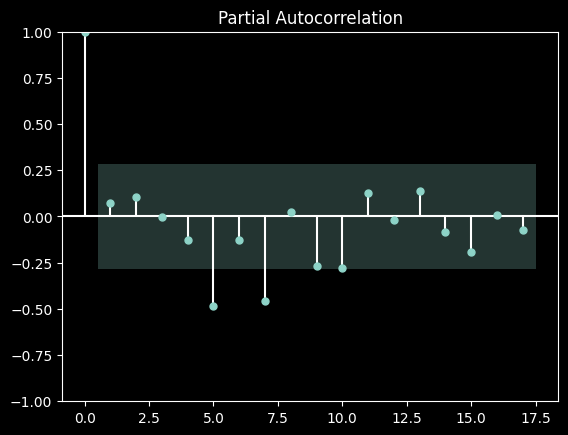

In [47]:
# ACF and PACF plots
acf_diff = plot_acf(df_train_diff['Prices'])
pacf_diff = plot_pacf(df_train_diff['Prices'])

# ADF test
adf_test(df_train_diff['Prices'])

- We conclude that first order differencing is the only one that is necessary

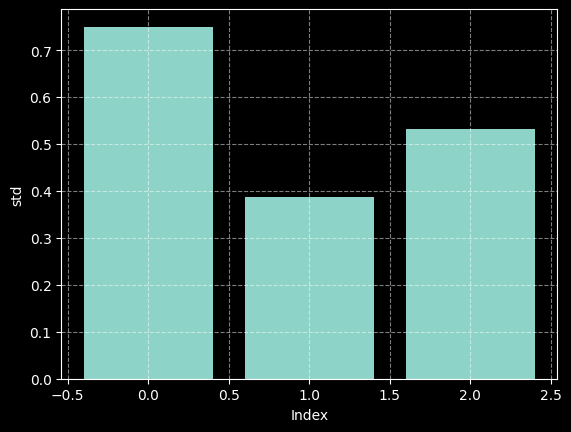

In [48]:
# Second order differencing
df_train_diff_2 = df_train_diff.diff().dropna()

# Observe std dev of the differencing and choose lowest
df_std_diff = pd.DataFrame({
    'std': [np.std(df_train['Prices']), np.std(df_train_diff['Prices']), np.std(df_train_diff_2['Prices'])]
})

fig, ax = plt.subplots()
ax.bar(df_std_diff.index, df_std_diff['std'])
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_ylabel('std')
ax.set_xlabel('Index')
plt.show()

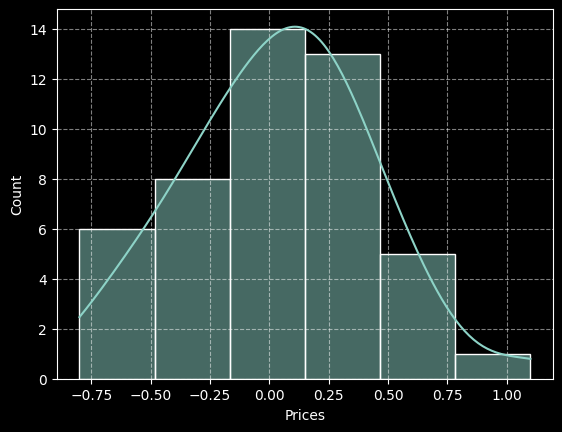

In [49]:
# View distribution of first order differencing
n_bins = int(np.log2(len(df_train_diff)) + 1) # Sturges' Rule
sns.histplot(df_train_diff['Prices'], bins=n_bins, kde=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## Step 3: Fit $\text{SARIMAX}$ model
- The model parameters are $(p, d, q)$ and $(P, D, Q)_s$
- First order differencing was sufficient to turn data stationary hence d = 1
- We observed from the ACF plot for the first-order differencing that the lag-11 and lag-12 autocorrelation had the highest in magnitude
- This implies a seasonality of period 11 or 12 or $s = 12$
- This makes sense as the data is monthly so we do expect a seasonality period of 12
- The seasonal pattern is still there so we can do $D = 1$

In [50]:
# Fit auto_arima
model = auto_arima(
    df_train['Prices'],
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,
    start_P=0, max_P=5,
    start_Q=0, max_Q=5,
    D=1,
    seasonal=True,
    m=12,
    stepwise=True,
    trace=True,
    suppress_warnings=True,
    error_action='ignore'
)

# Summary
print(model.summary())

c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=13.970, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=8.012, Time=0.20 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=68.315, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=15.872, Time=0.04 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3.100, Time=0.53 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=5.100, Time=0.52 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=5.099, Time=0.38 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.45 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=7.099, Time=0.76 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1.103, Time=0.37 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=7.455, Time=0.11 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=inf, Time=0.37 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=3.103, Time=0.25 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.26 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(3,1,1)[12] intercept   : AIC=5.103, Time=0.45 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=3.100, Time=0.43 sec


c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=5.098, Time=0.65 sec
 ARIMA(0,0,0)(2,1,0)[12]             : AIC=inf, Time=0.11 sec

Best model:  ARIMA(0,0,0)(2,1,0)[12] intercept
Total fit time: 6.212 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   48
Model:             SARIMAX(2, 1, 0, 12)   Log Likelihood                   3.448
Date:                  Mon, 07 Apr 2025   AIC                              1.103
Time:                          20:08:22   BIC                              7.437
Sample:                               0   HQIC                             3.314
                                   - 48                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

c:\Users\Babanz\anaconda3\envs\quant\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [79]:
# SARIMAX model
model = SARIMAX(
    df_train['Prices'],
    order=(1, 1, 1),
    seasonal_order=(2, 1, 0, 12)
)
model_fit = model.fit()
print(model_fit.summary())

# Perform prediction for next year
forecast = model_fit.get_forecast(steps=12)

# Get 95% confidence interval band
forecast_df = forecast.conf_int(alpha=0.05)

# Use the average forecast
forecast_df['Prediction'] = forecast.predicted_mean

                                      SARIMAX Results                                      
Dep. Variable:                              Prices   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                   0.751
Date:                             Mon, 07 Apr 2025   AIC                              8.499
Time:                                     20:32:21   BIC                             16.275
Sample:                                          0   HQIC                            11.183
                                              - 48                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1899      0.297     -0.638      0.523      -0.773       0.393
ma.L1         -0.6722      

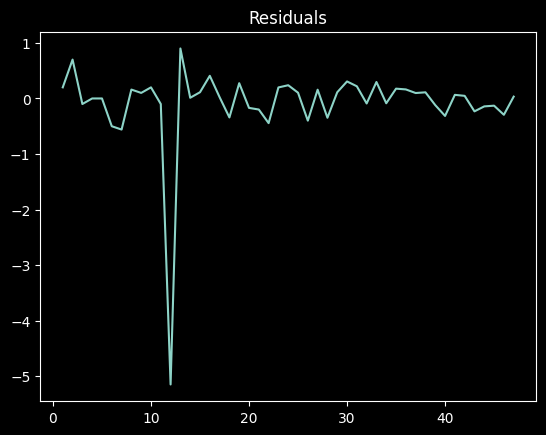

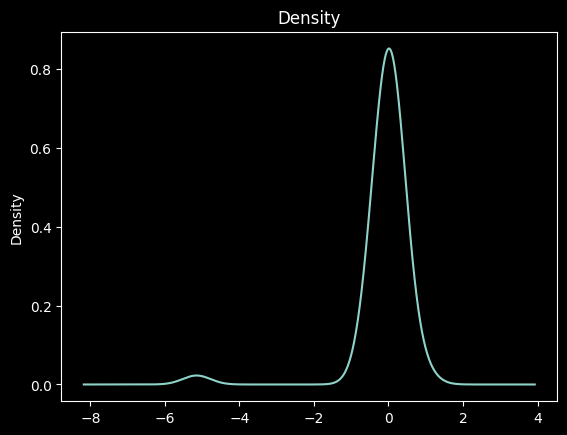

In [80]:
# Observe residuals
residuals = model_fit.resid[1:]
residuals.plot(title='Residuals')
plt.show()
residuals.plot(title='Density', kind='kde')
plt.show()

## Step 4: Make time-series prediction forecasts

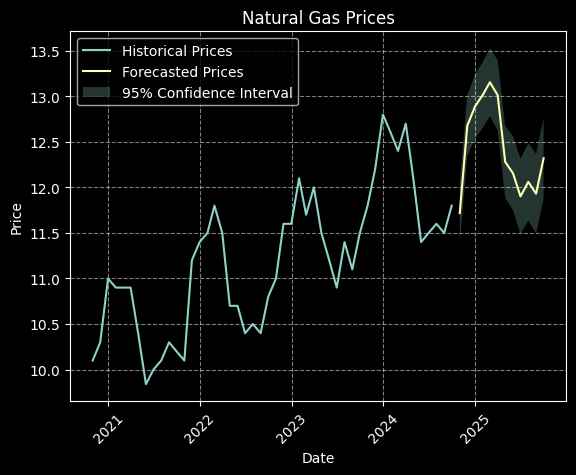

In [82]:
# Create forecast dates
last_date = df_train['Dates'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_df.index = forecast_dates

# Plot historical and time-series forecasted prices with 95% CI
dates = pd.to_datetime(df['Dates'])
fig, ax = plt.subplots()
ax.plot(dates, df['Prices'], label='Historical Prices')
ax.plot(forecast_df.index, forecast_df['Prediction'], label='Forecasted Prices')
ax.fill_between(
    forecast_df.index,
    forecast_df['lower Prices'],
    forecast_df['upper Prices'],
    alpha=0.25,
    label='95% Confidence Interval'
)
plot_format(ax=ax)
ax.tick_params(axis='x', rotation=45)
plt.show()